In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

%matplotlib inline
matplotlib.rc('font', family='AppleGothic')
plt.rc('font',  family='AppleGothic')
plt.rcParams['axes.unicode_minus']=False

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.svm import SVC

# 1.데이터 불러오기

In [4]:
pd.set_option('display.max_columns',None)
# df_raw = pd.read_csv('wo_thin.csv', engine='python', encoding='cp949')
df_raw = pd.read_csv('/Users/dasol/Documents/Job/포스코아카데미/강의자료/포스코/빅데이터프로젝트/A2_신용카드/df_final.csv', engine='python')#, encoding='cp949')

In [5]:
df_raw.columns

Index(['chaju_id', 'credit_class', 'score_risk', 'gender', 'age', 'agegroup',
       'job', 'edu', 'dwell_type', 'house_type', 'marriage', 'income_home_grp',
       'income_ind_grp', 'expenditure_grp', 'child_cd', 'no_child',
       'flag_priv_biz_cd', 'net_income', 'family_size', 'income_person',
       'card_count', 'loan_amt', 'loan_dur', 'loan_count', 'over_amt',
       'over_dur', 'over_count', 'is_overdue', 'sum_loan_at_time',
       'sum_cashservice_3y', 'sum_cardloan_3y', 'no_cashservice_3y',
       'no_cardloan_3y', 'no_creditcard_over', 'sum_creditcard_over',
       'max_loan_amt', 'max_over_amt', 'income_ind_test', 'expend_ind_test',
       'ind_net_income', 'loan_at_time_div_by_net', 'cardloan_no_diff_com',
       'cashservice_no_diff_com'],
      dtype='object')

In [6]:
# 1. 기존 모델과의 KS통계량 비교시 사용하는 데이터: 기존 모델에서 사용한 변수들과 비슷한 변수들만 사용하는 버전
# data=df_raw[['is_overdue','agegroup','job','edu','dwell_type','house_type','marriage',
#              'income_home_grp','expenditure_grp','card_count','loan_count',
#               'flag_priv_biz_cd', 'loan_amt',
#              'over_count','over_amt']]
# data['loan_amt']=np.log10(data['loan_amt']+1) # 금액의 범위가 너무 다양하므로 log로 변환 + 금액이0일 경우 log 에러 방지를 위해 +1
# data['over_amt']=np.log10(data['over_amt']+1)

# 2. 최종 모델에서 사용한 데이터: 기존 모델 변수들 - (대출금액, 연체금액) + 파생 변수
data = df_raw[['gender','agegroup','job','edu','dwell_type', 'house_type', 'flag_priv_biz_cd', 'card_count', 'loan_dur','loan_count',
 'over_dur', 'over_count', 'is_overdue', 'loan_at_time_div_by_net', 'cardloan_no_diff_com', 'cashservice_no_diff_com']]

In [7]:
list(data.columns)

['gender',
 'agegroup',
 'job',
 'edu',
 'dwell_type',
 'house_type',
 'flag_priv_biz_cd',
 'card_count',
 'loan_dur',
 'loan_count',
 'over_dur',
 'over_count',
 'is_overdue',
 'loan_at_time_div_by_net',
 'cardloan_no_diff_com',
 'cashservice_no_diff_com']

# ordinal encoding

In [8]:
numerical_feats = data.dtypes[data.dtypes != "object"].index.tolist()
numerical_feats.remove('is_overdue')
print(numerical_feats)
print("Number of Numerical features: ", len(numerical_feats))
print('\n')

categorical_feats = data.dtypes[data.dtypes == "object"].index.tolist()
print(categorical_feats)
print("Number of Categorical features: ", len(categorical_feats))

['card_count', 'loan_dur', 'loan_count', 'over_dur', 'over_count', 'loan_at_time_div_by_net', 'cardloan_no_diff_com', 'cashservice_no_diff_com']
Number of Numerical features:  8


['gender', 'agegroup', 'job', 'edu', 'dwell_type', 'house_type', 'flag_priv_biz_cd']
Number of Categorical features:  7


In [9]:
from category_encoders.ordinal import OrdinalEncoder
encoder = OrdinalEncoder(categorical_feats)
data[categorical_feats] = encoder.fit_transform(data[categorical_feats], data['is_overdue'])
# test[categorical_feats] = encoder.transform(test[categorical_feats])

df_raw_y=data["is_overdue"]
df_raw_x=data.drop("is_overdue",axis=1,inplace=False)

/Users/dasol/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


# train, test 데이터 생성

In [10]:
# 데이터 구성하기 - 데이터 분할
df_train_x,df_test_x,df_train_y,df_test_y=train_test_split(df_raw_x,df_raw_y,test_size=0.3,random_state=100)
print("train data X size :{}".format(df_train_x.shape))
print("train data Y size :{}".format(df_train_y.shape))
print("test data X size :{}".format(df_test_x.shape))
print("test data Y size :{}".format(df_test_y.shape))

train data X size :(1294, 15)
train data Y size :(1294,)
test data X size :(555, 15)
test data Y size :(555,)


# 3. SVC 모델 생성



## hyper parameter 튜닝 전 모델 정확도

#### randomstate(초기 자료 선택 기준)를 100으로 변경

Accuracy on svm_uncustomized training set:0.902
Accuracy on svm_uncustomized test set:0.875

In [11]:
svm_uncustomized=SVC(random_state=100)
svm_uncustomized.fit(df_train_x,df_train_y)

#train 데이터 정확도
print("Accuracy on svm_uncustomized training set:{:.3f}".format(svm_uncustomized.score(df_train_x,df_train_y)))
#test 데이터 정확도
print("Accuracy on svm_uncustomized test set:{:.3f}".format(svm_uncustomized.score(df_test_x,df_test_y)))

Accuracy on svm_uncustomized training set:0.950
Accuracy on svm_uncustomized test set:0.942


# 4-1. 모델 파라메터 조정 1: Cost =>10선택

## 4-1-1. Cost(0.01~10)에 따른 accuracy 변화

In [12]:
train_accuracy = []; test_accuracy =[]
para_c = [10**c for c in range(-2,2)]

for v_C in para_c:
    svm = SVC(C=v_C,random_state=100)
    svm.fit(df_train_x,df_train_y)
    train_accuracy.append(svm.score(df_train_x,df_train_y))
    test_accuracy.append(svm.score(df_test_x,df_test_y))
    
df_accuracy_c = pd.DataFrame()
df_accuracy_c["C"] = para_c
df_accuracy_c["Train Accuracy"]=train_accuracy
df_accuracy_c["Test Accuracy"]=test_accuracy

In [13]:
df_accuracy_c.round(3)

,C,Train Accuracy,Test Accuracy
0,0.01,0.836,0.820
1,0.10,0.938,0.942
2,1.00,0.950,0.942
3,10.00,0.961,0.942


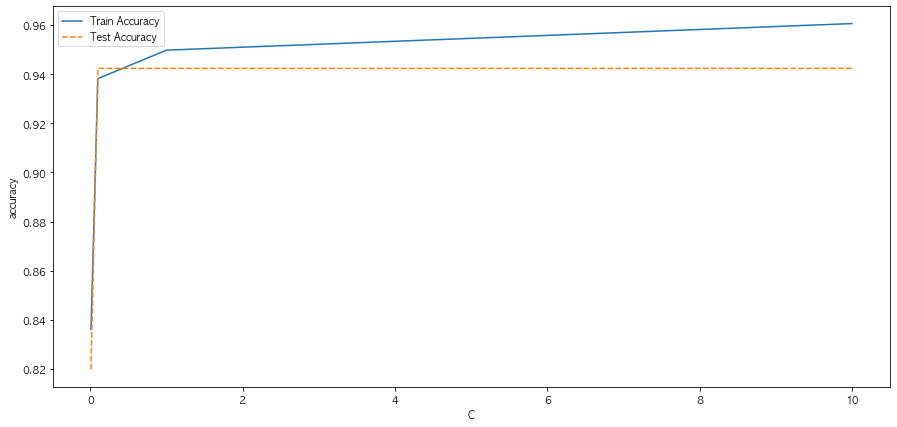

In [14]:
plt.figure(figsize=(15,7))
plt.plot(para_c,train_accuracy,linestyle='-',label="Train Accuracy")
plt.plot(para_c,test_accuracy,linestyle='--',label="Test Accuracy")
# plt.axvline(x=1, linestyle='--', c='r', label='주성분 2번')
plt.ylabel("accuracy");plt.xlabel("C")
plt.legend()

# 4-2.모델 파라메터 조정 2: gamma =>0.05선택

- gamma파라메터란?

gamma는 데이터의 영향력의 거리와 반비례관계이다.

gamma가 클수록 1개 데이터의 영향력 거리가 짧아져 과적합 위험이 있다.

### SVC 모델의 default 설정값 확인

In [15]:
SVC().get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

## 4-2-1. gamma(0.01~1)에 따른 accuracy 변화


In [16]:
train_accuracy = []; test_accuracy =[]
para_gamma = [10**gamma for gamma in range(-2,1)]

for v_gamma in para_gamma:
    svm = SVC(gamma=v_gamma,C=0.8,random_state=100)
    svm.fit(df_train_x,df_train_y)
    train_accuracy.append(svm.score(df_train_x,df_train_y))
    test_accuracy.append(svm.score(df_test_x,df_test_y))
    
df_accuracy_gamma = pd.DataFrame()
df_accuracy_gamma["gamma"] = para_gamma
df_accuracy_gamma["TrainAccuracy"]=train_accuracy
df_accuracy_gamma["TestAccuracy"]=test_accuracy

In [17]:
df_accuracy_gamma.round(4)

,gamma,TrainAccuracy,TestAccuracy
0,0.01,0.9490,0.9423
1,0.10,0.9714,0.9279
2,1.00,0.8756,0.8198


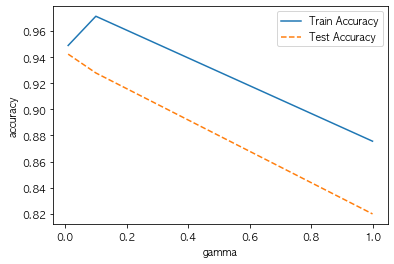

In [18]:
plt.plot(para_gamma,train_accuracy,linestyle='-',label="Train Accuracy")
plt.plot(para_gamma,test_accuracy,linestyle='--',label="Test Accuracy")
plt.ylabel("accuracy");plt.xlabel("gamma")
plt.legend()

# 5.Scale 변환

## 필요성:
SVM은 변수간 거리를 기반으로 데이터 군을 나누는 방법이므로,

변수간 scale 차이가 큰 경우 결과 도출에 영향을 줄 수 있다.

따라서 설명변수 값의 구간을 동일하게 변환하는 Standardscaler를 적용하였다.

### Scale 변환 결과: 평균이 0,  표준편차가 1로 변환된 것을 알 수 있다.

In [25]:
v_feature_name = df_train_x.columns
scaler = StandardScaler()
df_scaled=scaler.fit_transform(df_raw_x)
df_scaled=pd.DataFrame(df_scaled,columns=v_feature_name)
df_scaled.describe()

,gender,agegroup,job,edu,dwell_type,house_type,flag_priv_biz_cd,card_count,loan_dur,loan_count,over_dur,over_count,loan_at_time_div_by_net,cardloan_no_diff_com,cashservice_no_diff_com
count,1.849000e+03,1.849000e+03,1.849000e+03,1.849000e+03,1.849000e+03,1.849000e+03,1.849000e+03,1.849000e+03,1.849000e+03,1.849000e+03,1.849000e+03,1.849000e+03,1.849000e+03,1.849000e+03,1.849000e+03
mean,4.918846e-16,-4.371240e-17,-9.901340e-17,4.601286e-17,-4.215125e-17,4.448097e-16,7.037817e-16,4.803561e-17,-1.911517e-16,-8.598374e-17,1.302966e-16,3.465169e-16,-5.795496e-16,2.166406e-16,-1.621202e-16
std,1.000271e+00,1.000271e+00,1.000271e+00,1.000271e+00,1.000271e+00,1.000271e+00,1.000271e+00,1.000271e+00,1.000271e+00,1.000271e+00,1.000271e+00,1.000271e+00,1.000271e+00,1.000271e+00,1.000271e+00
min,-9.044846e-01,-1.360578e+00,-1.179163e+00,-1.046000e+00,-4.697739e-01,-7.192858e-01,-3.304212e-01,-1.343234e+00,-1.163409e+00,-8.349304e-01,-4.333096e-01,-3.792245e-01,-1.201424e+00,-4.044616e-01,-4.677757e-01
25%,-9.044846e-01,-7.605999e-01,-7.258838e-01,-1.046000e+00,-4.697739e-01,-7.192858e-01,-3.304212e-01,-7.032856e-01,-1.163409e+00,-8.349304e-01,-4.333096e-01,-3.792245e-01,-7.360926e-01,-4.044616e-01,-4.677757e-01
50%,-9.044846e-01,-1.606216e-01,-2.726048e-01,2.431212e-02,-4.697739e-01,-7.192858e-01,-3.304212e-01,-6.333724e-02,2.634532e-02,-4.396958e-01,-4.333096e-01,-3.792245e-01,-6.585928e-01,-4.044616e-01,-4.677757e-01
75%,1.105602e+00,1.039335e+00,1.087232e+00,5.594683e-01,-4.697739e-01,3.717392e-01,-3.304212e-01,5.766112e-01,9.186610e-01,3.507734e-01,-4.333096e-01,-3.792245e-01,5.163892e-01,-4.044616e-01,-4.677757e-01
max,1.105602e+00,2.239292e+00,1.540511e+00,3.770405e+00,6.369690e+00,4.735839e+00,3.026440e+00,3.776353e+00,1.414392e+00,4.303119e+00,2.895473e+00,8.237502e+00,3.521152e+00,6.425214e+00,5.112336e+00


## Scale 변환 이전 데이터와, C=10,gamma=0.05로 학습한 모델의 정확도

In [22]:
svm_original = SVC(C=10,gamma=0.05,random_state=100)
svm_original.fit(df_train_x,df_train_y)

#train 데이터 정확도
print("Accuracy on svm scale 이전 training set:{:.3f}".format(svm_original.score(df_train_x,df_train_y)))
#test 데이터 정확도
print("Accuracy on svm scaled 이전 test set:{:.3f}".format(svm_original.score(df_test_x,df_test_y)))

Accuracy on svm scale 이전 training set:0.992
Accuracy on svm scaled 이전 test set:0.932


# 6.Scale 변환된 데이터로 SVM 모델 생성
## Scale 변환된 데이터로 train, test 데이터 생성

## 모델 정확도


In [23]:
df_scaled_train_x, df_scaled_test_x, = train_test_split(df_scaled, test_size = 0.3, random_state=100)
print("train data X szie {}".format(df_scaled_train_x.shape))
print("test data Y szie {}".format(df_scaled_test_x.shape))

train data X szie (1294, 15)
test data Y szie (555, 15)


In [24]:
svm_scaled = SVC(random_state=100)
svm_scaled.fit(df_scaled_train_x,df_train_y)
#train 데이터 정확도
print("Accuracy on svm scale 이후 training set:{:.3f}".format(svm_scaled.score(df_scaled_train_x,df_train_y)))
#test 데이터 정확도
print("Accuracy on svm_scale 이후 test set:{:.3f}".format(svm_scaled.score(df_scaled_test_x,df_test_y)))

Accuracy on svm scale 이후 training set:0.954
Accuracy on svm_scale 이후 test set:0.942


# 7-1. 모델 파라메터 조정: Cost =>1선택
train, test 정확도가 95% 정도로 높고 train, test 정확도 차이가 작은 1 선택

In [26]:
train_accuracy = []; test_accuracy =[]
para_c = [10**c for c in range(-2,2)]

for v_C in para_c:
    svm = SVC(C=v_C,random_state=100)
    svm.fit(df_scaled_train_x,df_train_y)
    train_accuracy.append(svm.score(df_scaled_train_x,df_train_y))
    test_accuracy.append(svm.score(df_scaled_test_x,df_test_y))
    
df_accuracy_c = pd.DataFrame()
df_accuracy_c["C"] = para_c
df_accuracy_c["TrainAccuracy"]=train_accuracy
df_accuracy_c["TestAccuracy"]=test_accuracy

In [27]:
df_accuracy_c.round(4)

,C,TrainAccuracy,TestAccuracy
0,0.01,0.8362,0.8198
1,0.10,0.9312,0.9189
2,1.00,0.9536,0.9423
3,10.00,0.9791,0.9315


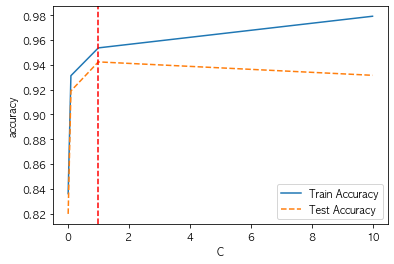

In [28]:
plt.plot(para_c,train_accuracy,linestyle='-',label="Train Accuracy")
plt.plot(para_c,test_accuracy,linestyle='--',label="Test Accuracy")
plt.ylabel("accuracy");plt.xlabel("C")
plt.axvline(x=1, linestyle='--', c='r')
plt.legend()

# 7-2.모델 파라메터 조정 : gamma =>0.1선택


## 7-2-1. gamma(0.01~10)에 따른 accuracy 변화


In [29]:
train_accuracy = []; test_accuracy =[]
para_gamma = [10**gamma for gamma in range(-2,2)]

for v_gamma in para_gamma:
    svm = SVC(gamma=v_gamma,C=1,random_state=100)
    svm.fit(df_scaled_train_x,df_train_y)
    train_accuracy.append(svm.score(df_scaled_train_x,df_train_y))
    test_accuracy.append(svm.score(df_scaled_test_x,df_test_y))
    
df_accuracy_gamma = pd.DataFrame()
df_accuracy_gamma["gamma"] = para_gamma
df_accuracy_gamma["TrainAccuracy"]=train_accuracy
df_accuracy_gamma["TestAccuracy"]=test_accuracy

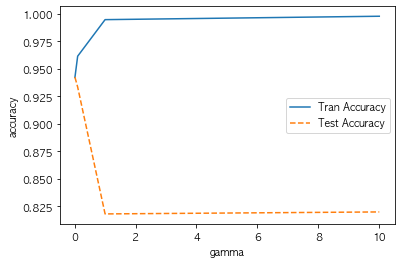

In [30]:
df_accuracy_c.round(3)
plt.plot(para_c,train_accuracy,linestyle='-',label="Tran Accuracy")
plt.plot(para_c,test_accuracy,linestyle='--',label="Test Accuracy")
plt.ylabel("accuracy");plt.xlabel("gamma")
plt.legend()

## 7-2-2. gamma(0.1~0.5)에 따른 accuracy 변화
gamma가 증가하면서 test 정확도가 급격히 감소하므로 0.1을 선택했습니다.

In [31]:
train_accuracy = []; test_accuracy =[]
para_gamma = [gamma*0.1 for gamma in range(1,5)]


for v_gamma in para_gamma:
    svm = SVC(gamma=v_gamma,C=1,random_state=100)
    svm.fit(df_scaled_train_x,df_train_y)
    train_accuracy.append(svm.score(df_scaled_train_x,df_train_y))
    test_accuracy.append(svm.score(df_scaled_test_x,df_test_y))
    
df_accuracy_gamma = pd.DataFrame()
df_accuracy_gamma["gamma"] = para_gamma
df_accuracy_gamma["TrainAccuracy"]=train_accuracy
df_accuracy_gamma["TestAccuracy"]=test_accuracy

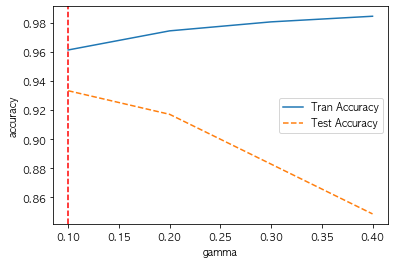

In [32]:
df_accuracy_c.round(3)
plt.plot(para_gamma,train_accuracy,linestyle='-',label="Tran Accuracy")
plt.plot(para_gamma,test_accuracy,linestyle='--',label="Test Accuracy")
plt.axvline(x=0.1, linestyle='--', c='r')
plt.ylabel("accuracy");plt.xlabel("gamma")
plt.legend()

In [33]:
df_accuracy_gamma.round(4)

,gamma,TrainAccuracy,TestAccuracy
0,0.1,0.9614,0.9333
1,0.2,0.9745,0.9171
2,0.3,0.9807,0.8829
3,0.4,0.9845,0.8486


## GridSearchCV를 통한 Hyperparemter 탐색과 모델 정확도

In [54]:
estimaotr = SVC(random_state=100)
param_grid={"C":para_c,"gamma":para_gamma}
grid_rf=GridSearchCV(estimaotr,param_grid,scoring="accuracy",n_jobs=-1)
grid_rf.fit(df_scaled_train_x,df_train_y)
print("best estimator model:\n{}".format(grid_rf.best_estimator_))
print("\nbest parameter:\n{}".format(grid_rf.best_params_))
print("\nbest score \n{}".format(grid_rf.best_score_.round(3)))

best estimator model:
SVC(C=1, gamma=0.1, random_state=100)

best parameter:
{'C': 1, 'gamma': 0.1}

best score 
0.935


# 8.최종 모델
# 1) 하이퍼파라메터 ( C =1, gamma=0.1 )
C, gamma 파라메터 튜닝한 결과와 GridSearchCV로 도출한 하이퍼파라메터가 일치하여 선택하였다.

# 2) 모델 평가

## 📌 해석: accuracy

C, gamma 파라메터 튜닝한 SVM 모델의 test 정확도는 93.3%으로 튜닝 전 94.2%보다 0.9 감소하였다.

C, gamma 파라메터 튜닝한 SVM 모델은 RandomForest 모델의 test 정확도 93.2%보다 0.1 증가하였으므로 정확도면에선 비슷한 성능을 보인다.


## 📌 해석: f1-score
C, gamma 파라메터 튜닝한 SVM 모델의 목표 변수 1기준 f1-score은 0.827으로 RandomForest 모델 결과인 0.81보다 크다.

# 3) 모델 선택
## 📌 결론: 
### C, gamma 파라메터 튜닝한 SVM 모델이 RandomForest 모델보다 Accuracy와 f1-score은 높다.

### 하지만 신용평점시스템에 중요한 성능지표인 "변별력"은 43.8%로 RF모델의 65%보다 현저하게 낮으며 기존 신용평점시스템 39.4%보다 크게 증가하지 않았다.

### 따라서 RF모델을 최종 모델로 선정하였다.

In [34]:
list(df_scaled_train_x.columns)

['gender',
 'agegroup',
 'job',
 'edu',
 'dwell_type',
 'house_type',
 'flag_priv_biz_cd',
 'card_count',
 'loan_dur',
 'loan_count',
 'over_dur',
 'over_count',
 'loan_at_time_div_by_net',
 'cardloan_no_diff_com',
 'cashservice_no_diff_com']

In [35]:
svc_final = SVC(gamma=0.1,C=1,random_state=100, probability=True, kernel='linear')
svc_final.fit(df_scaled_train_x,df_train_y)
y_pred = svc_final.predict(df_scaled_test_x)
print("Accuracy on training set:{:.3f}".format(svc_final.score(df_scaled_train_x,df_train_y)))
print("Accuracy on test set:{:.3f}".format(svc_final.score(df_scaled_test_x,df_test_y)))
print("\nAccuracy on test set\n:{}".format(confusion_matrix(df_test_y,y_pred)))

print(classification_report(df_test_y,y_pred,digits=3))

Accuracy on training set:0.943
Accuracy on test set:0.941

Accuracy on test set
:[[443  12]
 [ 21  79]]
              precision    recall  f1-score   support

         0.0      0.955     0.974     0.964       455
         1.0      0.868     0.790     0.827       100

    accuracy                          0.941       555
   macro avg      0.911     0.882     0.896       555
weighted avg      0.939     0.941     0.939       555



In [36]:
prob = svc_final.predict_proba(df_scaled)
prob

array([[0.94781541, 0.05218459],
       [0.98715478, 0.01284522],
       [0.95351212, 0.04648788],
       ...,
       [0.98352899, 0.01647101],
       [0.98848282, 0.01151718],
       [0.95322989, 0.04677011]])

In [37]:
prob_1_score = [i*1000 for i in prob[:,1]]

Text(0, 0.5, 'Prob * 1000')

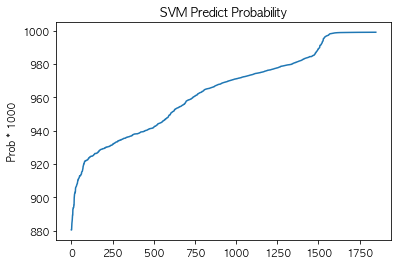

In [38]:
import numpy as np

risk_score = [(1-1/i)*1000 for i in prob_1_score]

sns.lineplot(x=range(len(prob_1_score)), y=sorted(risk_score))

plt.title('SVM Predict Probability')
plt.ylabel('Prob * 1000')

In [39]:
risk_score

[980.8372540856116,
 922.1500042227849,
 978.4890190711066,
 937.001794439319,
 974.7288987373688,
 966.0064995057463,
 950.8508412456559,
 984.5108950668301,
 973.018708647165,
 923.8564505432846,
 929.7369919872963,
 915.1916294760236,
 976.1104393613645,
 947.6038109603232,
 944.1718233029286,
 943.4618108374326,
 944.7236966026844,
 998.9667453240759,
 974.294479831434,
 962.6198338498751,
 976.800249023442,
 942.9245179871591,
 939.4718551705953,
 955.8166011785814,
 939.1176415484899,
 930.8333496058495,
 942.5427419520033,
 998.795688613735,
 978.8220045687816,
 928.9525469217656,
 934.7829527191244,
 974.5357631480823,
 939.6484774359255,
 998.8309570284555,
 981.2889626974354,
 919.3516270761262,
 998.9556393028384,
 954.1605772683394,
 957.9576789115347,
 950.6503864534774,
 968.8647147305815,
 958.7979835350096,
 998.1859911337538,
 998.8445343880097,
 983.6285844248897,
 997.9311646756798,
 955.229693914343,
 998.9999973609372,
 931.8754027065573,
 944.0866436208738,
 985.3

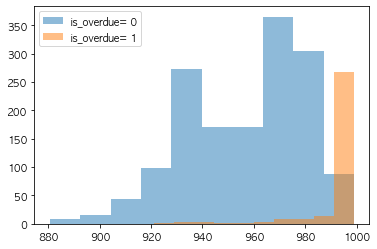

In [40]:
df = pd.DataFrame({'risk_score':risk_score})
df['is_overdue'] = df_raw_y


plt.hist(df[df['is_overdue']==0]['risk_score'], alpha=0.5, label='is_overdue= 0')
plt.hist(df[df['is_overdue']==1]['risk_score'], alpha=0.5, label='is_overdue= 1')
plt.legend()
plt.show()

In [41]:
def cal_credit_class(risk_score):    
    df = pd.DataFrame({'risk_score':risk_score})
    df['class'] = risk_score
    df['is_overdue'] = df_raw_y
    df.loc[df['risk_score'] < 930, 'class'] = 'un_C03'
    df.loc[((df['risk_score'] >= 930)&(df['risk_score'] < 940)), 'class'] = 'C04'
    df.loc[((df['risk_score'] >= 940)&(df['risk_score'] < 950)), 'class'] = 'C05'
    df.loc[((df['risk_score'] >= 950)&(df['risk_score'] < 960)), 'class'] = 'C06'
    df.loc[(df['risk_score'] >= 960), 'class'] = 'over_C07'
    return df

df_class = cal_credit_class(risk_score)
df_class

,risk_score,class,is_overdue
0,980.837254,over_C07,1.0
1,922.150004,un_C03,0.0
2,978.489019,over_C07,0.0
3,937.001794,C04,0.0
4,974.728899,over_C07,0.0
...,...,...,...
1844,988.333004,over_C07,0.0
1845,974.963006,over_C07,0.0
1846,939.287267,C04,0.0
1847,913.173160,un_C03,0.0


In [42]:
table=pd.crosstab(df_class['class'],df_class['is_overdue'], margins=True)

In [43]:
table

is_overdue,0.0,1.0,All
class,,,
C04,235,2,237
C05,150,4,154
C06,135,2,137
over_C07,809,301,1110
un_C03,208,3,211
All,1537,312,1849


In [44]:
table = table.reindex(index=['un_C03','C04','C05','C06','over_C07','All'])

In [45]:
table

is_overdue,0.0,1.0,All
class,,,
un_C03,208,3,211
C04,235,2,237
C05,150,4,154
C06,135,2,137
over_C07,809,301,1110
All,1537,312,1849


In [46]:
table['0_cum']=table[0.0]/1537


In [47]:
table

is_overdue,0.0,1.0,All,0_cum
class,,,,
un_C03,208,3,211,0.135329
C04,235,2,237,0.152895
C05,150,4,154,0.097593
C06,135,2,137,0.087833
over_C07,809,301,1110,0.526350
All,1537,312,1849,1.000000


In [48]:
table['1_cum']=table[1.0]/312
table

is_overdue,0.0,1.0,All,0_cum,1_cum
class,,,,,
un_C03,208,3,211,0.135329,0.009615
C04,235,2,237,0.152895,0.006410
C05,150,4,154,0.097593,0.012821
C06,135,2,137,0.087833,0.006410
over_C07,809,301,1110,0.526350,0.964744
All,1537,312,1849,1.000000,1.000000


In [49]:
ks_fin=table[['0_cum','1_cum']]
ks_fin

is_overdue,0_cum,1_cum
class,,
un_C03,0.135329,0.009615
C04,0.152895,0.006410
C05,0.097593,0.012821
C06,0.087833,0.006410
over_C07,0.526350,0.964744
All,1.000000,1.000000


In [50]:
ks_fin['index'] = ks_fin.index
ks_fin

<ipython-input-50-ca921d0f5812>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ks_fin['index'] = ks_fin.index


is_overdue,0_cum,1_cum,index
class,,,
un_C03,0.135329,0.009615,un_C03
C04,0.152895,0.006410,C04
C05,0.097593,0.012821,C05
C06,0.087833,0.006410,C06
over_C07,0.526350,0.964744,over_C07
All,1.000000,1.000000,All


In [51]:
ks_fin['0_cum']=  ks_fin['0_cum'].cumsum()
ks_fin['1_cum']=  ks_fin['1_cum'].cumsum()
ks_fin

<ipython-input-51-1e996fe2d868>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ks_fin['0_cum']=  ks_fin['0_cum'].cumsum()
<ipython-input-51-1e996fe2d868>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ks_fin['1_cum']=  ks_fin['1_cum'].cumsum()


is_overdue,0_cum,1_cum,index
class,,,
un_C03,0.135329,0.009615,un_C03
C04,0.288224,0.016026,C04
C05,0.385817,0.028846,C05
C06,0.473650,0.035256,C06
over_C07,1.000000,1.000000,over_C07
All,2.000000,2.000000,All


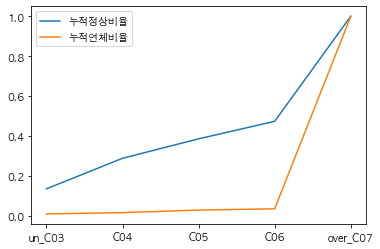

In [52]:
ks_fin=ks_fin.drop(index=['All'])
plt.plot(ks_fin['index'], ks_fin['0_cum'],label='누적정상비율')
plt.plot(ks_fin['index'],ks_fin['1_cum'],label='누적연체비율')

plt.legend()

# 📌 K-S 통계량

In [53]:
round(abs(ks_fin['1_cum']-ks_fin['0_cum']).max(), 5)*100

43.839